In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import pickle

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
slides_train = list(set(["BAL_Cat_Turnbull blue_1.svs"]))

slides_val = list(set(["BAL_Cat_Turnbull blue_12.svs", "BAL_Cat_Turnbull blue_10.svs"]))

In [7]:
grade_list = [0, 1]
annotations_path = Path("../../Statistics/SDATA_Final_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)
annotations["image_name"] = [name.replace("tiff","svs") for name in annotations["image_name"]]
annotations = annotations[annotations["grade"].isin(grade_list)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_train.head()

,id,image_id,image_set,species,image_name,image_type,grade,vector,unique_identifier,user_id,deleted,last_editor,data_set_name,version
838127,780409,3540,222,felis catus,BAL_Cat_Turnbull blue_13.svs,TurnbullBlue,0,"{'x1': 14559.0, 'x2': 14695.0, 'y1': 13830.0, ...",f0101356-7184-46be-9256-156df0b2f51b,1,False,1,SDATA,Inference
838128,780410,3540,222,felis catus,BAL_Cat_Turnbull blue_13.svs,TurnbullBlue,0,"{'x1': 28005.0, 'x2': 28144.0, 'y1': 19621.0, ...",60dcb09c-ab6a-4b1b-bd18-2ded7ea9e56c,1,False,1,SDATA,Inference
838129,780411,3540,222,felis catus,BAL_Cat_Turnbull blue_13.svs,TurnbullBlue,0,"{'x1': 9044.0, 'x2': 9144.0, 'y1': 11491.0, 'y...",13f92459-d556-4988-998b-e3e9fbd703c5,1,False,1,SDATA,Inference
838130,780412,3540,222,felis catus,BAL_Cat_Turnbull blue_13.svs,TurnbullBlue,0,"{'x1': 21019.0, 'x2': 21148.0, 'y1': 23674.0, ...",fe9dc34a-d78d-4980-84cd-3dba4550116f,1,False,1,SDATA,Inference
838131,780413,3540,222,felis catus,BAL_Cat_Turnbull blue_13.svs,TurnbullBlue,0,"{'x1': 15393.0, 'x2': 15538.0, 'y1': 10072.0, ...",a10e9390-bab1-469f-a577-c349463abcdc,1,False,1,SDATA,Inference


In [8]:
slides_path = Path("../../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs")  if slide.name in slides_train + slides_val}
files

{'BAL_Cat_Turnbull blue_1.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_1.svs'),
 'BAL_Cat_Turnbull blue_10.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_10.svs'),
 'BAL_Cat_Turnbull blue_13.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_13.svs')}

In [9]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [14]:
size = 1024 
level = 0
bs = 8
val_images = 1500

In [15]:
def get_y_func(x):
    return x.y

In [16]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [17]:
for i in [8,16,32,64,128,256,512,1024,2048]: #1,2,4,
    train_images = i

    train_files = []
    val_files = []
    
    experiment_name = "CatVsCat-Ablation_Patches_{}".format(i)

    #for image_name in slides_train[:i+1]:

    annotations = annotations_train[annotations_train["image_name"] == 'BAL_Cat_Turnbull blue_13.svs']
    annotations = annotations[annotations["deleted"] == False]

    slide_path = files['BAL_Cat_Turnbull blue_13.svs']
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]

    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))

    for image_name in annotations_val["image_name"].unique():

        annotations = annotations_val[annotations_val["image_name"] == image_name]
        annotations = annotations[annotations["deleted"] == False]

        slide_path = files[image_name]
        labels =  list(annotations["grade"])
        bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]

        val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
    train_files = list(np.random.choice(train_files, train_images))
    valid_files = list(np.random.choice(val_files, val_images))
    
    train =  ObjectItemListSlide(train_files, path=slides_path)
    valid = ObjectItemListSlide(valid_files, path=slides_path)
    item_list = ItemLists(slides_path, train, valid)
    lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
    lls = lls.transform(tfms, tfm_y=True, size=size)
    data = lls.databunch(bs=bs, collate_fn=bb_pad_collate).normalize()  #, num_workers=0
    
    crit = RetinaNetFocalLoss(anchors)
    encoder = create_body(models.resnet18, True, -2)
    model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)
    
    voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
    learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, partial(CSVLogger, append=False, filename=experiment_name)], #BBMetrics, ShowGraph
                    metrics=[voc])

    learn.split([model.encoder[6], model.c5top5])
    learn.freeze_to(-2)
    
    
    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-3)
    
    stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": 6,
         "n_anchors": 5,
         "sizes": [32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 3,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

    torch.save(stats, "{}.p".format(experiment_name))

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,3.496081,3.379010,0,0.532706,2.846304,0,0,01:21
1,3.437380,2.223449,0.000000,0.505739,1.717709,0.000000,0.000000,01:14
2,3.057370,258.536285,0.039235,1.207887,257.328400,0.072046,0.006423,18:42
3,17.318619,2.923980,0,0.544547,2.379433,0,0,01:21
4,14.271008,3.737690,0,0.579120,3.158571,0,0,01:21
5,12.409319,3.894841,0,0.547994,3.346847,0,0,01:21
6,11.100258,3.830975,0,0.500750,3.330226,0,0,01:21
7,10.109613,3.739809,0,0.480622,3.259187,0,0,01:20
8,9.334930,3.689239,0,0.480316,3.208923,0,0,01:21
9,8.713960,3.668067,0,0.479248,3.188818,0,0,01:23


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,3.428869,3.198600,0,0.496425,2.702174,0,0,01:24
1,2.985651,124.865913,0.081235,0.713654,124.152313,0.148589,0.013880,31:00
2,5.842006,3.380660,0,0.511398,2.869262,0,0,01:20
3,5.175706,3.748738,0,0.632161,3.116577,0,0,01:20
4,4.797907,3.213156,0.000000,0.501532,2.711624,0.000000,0.000000,01:20
5,4.368671,7.655318,0.074939,0.465603,7.189717,0.149878,0.000000,27:51
6,3.956464,4.762777,0.118134,0.509061,4.253716,0.236269,0.000000,26:25
7,3.541852,2.401893,0.102311,0.571345,1.830547,0.204622,0.000000,26:20
8,3.213367,2.125144,0.089545,0.501023,1.624122,0.175752,0.003337,27:44
9,2.946708,1.693179,0.086567,0.465126,1.228053,0.169450,0.003685,26:51


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,3.178461,1.777937,0.011327,0.608736,1.169201,0.022655,0.000000,01:37
1,3.174053,3.071259,0,0.526899,2.544360,0,0,01:22
2,2.827907,2.543580,0.007979,0.512580,2.030999,0.015958,0.000000,01:51
3,2.494376,1.856759,0.118705,0.500549,1.356210,0.235658,0.001751,24:25
4,2.093867,1.846991,0.180947,0.360816,1.486175,0.357639,0.004255,23:20
5,1.813094,1.064083,0.255160,0.309045,0.755039,0.374146,0.136175,17:37
6,1.595407,0.910401,0.310482,0.295251,0.615150,0.401687,0.219278,19:31
7,1.422385,0.898014,0.215851,0.267686,0.630329,0.421181,0.010522,17:21
8,1.282604,0.865895,0.215764,0.254028,0.611868,0.419122,0.012406,16:40
9,1.169812,0.815047,0.216632,0.249952,0.565095,0.409393,0.023872,18:29


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,2.887939,8.379356,0.094063,0.497637,7.881716,0.188126,0.000000,24:30
1,1.996007,1.864675,0.049196,0.430609,1.434066,0.096361,0.002031,24:26
2,1.514732,1.660789,0.150739,0.403788,1.257001,0.301454,0.000023,23:30
3,1.199897,2.161897,0.379164,0.313389,1.848508,0.312699,0.445629,28:59
4,0.976185,1.212996,0.473622,0.193213,1.019783,0.351169,0.596074,27:46
5,0.818704,0.702855,0.545093,0.159307,0.543548,0.581923,0.508262,21:12
6,0.699374,0.458561,0.614676,0.150399,0.308161,0.656102,0.573249,17:52
7,0.608601,0.434137,0.597833,0.129411,0.304726,0.651471,0.544194,17:30
8,0.540081,0.410488,0.614900,0.121091,0.289397,0.680909,0.548891,15:50
9,0.484290,0.408334,0.635121,0.124875,0.283459,0.678132,0.592109,14:26


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,2.090809,2.166492,0.021023,0.456553,1.709938,0.042046,0.000000,12:06
1,1.381006,0.940164,0.348956,0.271143,0.669021,0.331843,0.366069,25:36
2,0.972543,0.644850,0.468665,0.200975,0.443876,0.495178,0.442153,22:43
3,0.726670,0.585355,0.496531,0.145945,0.439410,0.671069,0.321993,15:14
4,0.564024,0.363347,0.684307,0.116241,0.247106,0.690085,0.678528,16:37
5,0.456421,0.349803,0.658052,0.109257,0.240546,0.708879,0.607225,12:26
6,0.387390,0.308669,0.752759,0.106043,0.202626,0.747770,0.757748,15:31
7,0.331167,0.292473,0.750419,0.092241,0.200232,0.755027,0.745810,13:16
8,0.284808,0.280336,0.770211,0.088862,0.191474,0.756086,0.784337,14:55
9,0.253774,0.279377,0.769458,0.087578,0.191798,0.753861,0.785055,14:46


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,1.470511,1.275923,0.142387,0.375611,0.900312,0.149742,0.135032,15:37
1,0.804092,0.648594,0.499956,0.234066,0.414528,0.588936,0.410977,20:01
2,0.513580,0.411189,0.669135,0.140861,0.270328,0.687115,0.651155,19:43
3,0.369728,0.424594,0.678153,0.136206,0.288388,0.676649,0.679657,13:50
4,0.279095,0.296834,0.642308,0.080709,0.216124,0.742573,0.542042,12:32
5,0.230565,0.317694,0.725512,0.095263,0.222431,0.770735,0.680288,14:41
6,0.197241,0.236189,0.799938,0.076953,0.159236,0.778029,0.821846,14:20
7,0.171710,0.235200,0.774785,0.067306,0.167894,0.799945,0.749625,12:04
8,0.156871,0.219598,0.788963,0.062756,0.156842,0.819138,0.758788,13:29
9,0.148277,0.212930,0.801148,0.061976,0.150954,0.826312,0.775985,13:18


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,0.955560,0.795605,0.363228,0.255435,0.540170,0.348897,0.377558,24:01
1,0.417339,0.444080,0.641719,0.125012,0.319068,0.713621,0.569817,16:38
2,0.270499,0.355619,0.645047,0.094817,0.260802,0.722460,0.567635,13:22
3,0.218202,0.346559,0.711585,0.104103,0.242456,0.776393,0.646776,15:09
4,0.184865,0.312413,0.749894,0.101580,0.210833,0.675680,0.824109,15:58
5,0.166872,0.295905,0.675606,0.071996,0.223909,0.760074,0.591138,13:00
6,0.148678,0.213939,0.786812,0.062056,0.151883,0.752032,0.821592,13:37
7,0.138035,0.198977,0.824414,0.059325,0.139651,0.807787,0.841040,13:26
8,0.124335,0.189075,0.816977,0.055709,0.133366,0.831950,0.802005,12:34
9,0.118972,0.190297,0.816920,0.055984,0.134313,0.848881,0.784958,11:47


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,0.481726,0.538447,0.525541,0.141238,0.397209,0.631662,0.419420,19:27
1,0.233999,0.306596,0.678188,0.088396,0.218201,0.715012,0.641365,13:38
2,0.190754,0.327661,0.745297,0.110751,0.216910,0.717356,0.773239,13:28
3,0.172349,0.238922,0.782659,0.071197,0.167725,0.811664,0.753653,14:54
4,0.155887,0.273520,0.737572,0.063766,0.209753,0.810010,0.665135,14:26
5,0.139213,0.279341,0.724764,0.085831,0.193510,0.598246,0.851282,17:55
6,0.128778,0.221957,0.804182,0.059469,0.162488,0.836176,0.772188,15:23
7,0.117324,0.188982,0.814478,0.052932,0.136051,0.830215,0.798741,12:53
8,0.107622,0.171085,0.849785,0.050790,0.120295,0.851320,0.848250,15:13
9,0.100787,0.179410,0.830139,0.051619,0.127791,0.862015,0.798263,14:39


epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,time
0,0.239563,0.332720,0.763109,0.097384,0.235337,0.712468,0.813749,18:45
1,0.182895,0.305642,0.715805,0.083199,0.222442,0.758807,0.672804,15:11
2,0.173942,0.259339,0.725754,0.070519,0.188820,0.794160,0.657348,13:31
3,0.156223,0.353468,0.683941,0.079613,0.273855,0.765988,0.601895,17:16
4,0.140794,0.210265,0.802019,0.061188,0.149077,0.847231,0.756807,15:04
5,0.121817,0.217316,0.813119,0.061974,0.155342,0.798118,0.828120,16:47
6,0.111538,0.196510,0.826371,0.059444,0.137067,0.775499,0.877243,14:18
7,0.098860,0.196860,0.796558,0.052305,0.144555,0.852801,0.740314,14:36
8,0.093892,0.165317,0.842729,0.048736,0.116581,0.840823,0.844635,14:44
9,0.087424,0.166819,0.840734,0.047913,0.118906,0.857875,0.823592,14:50


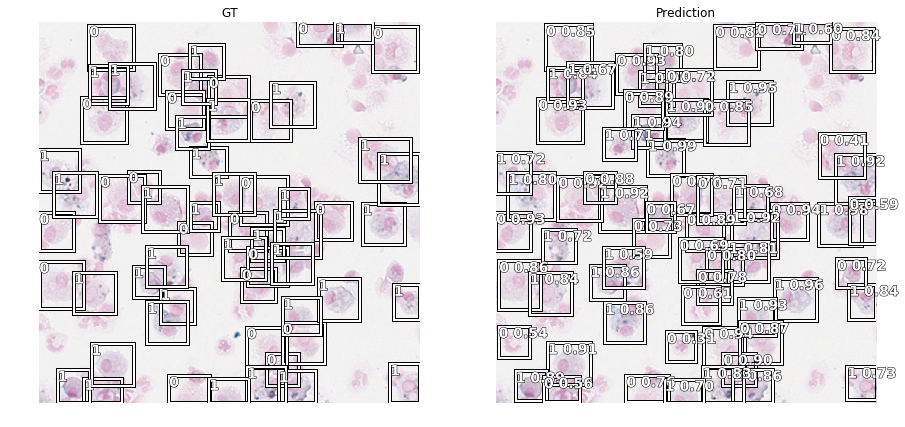

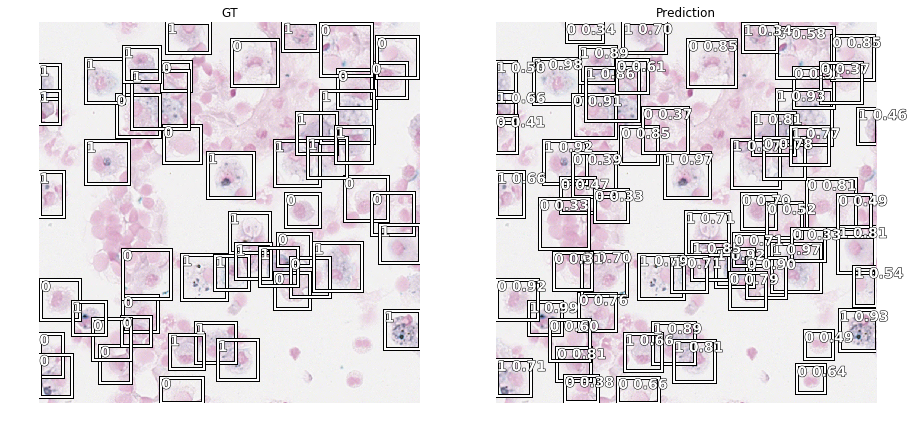

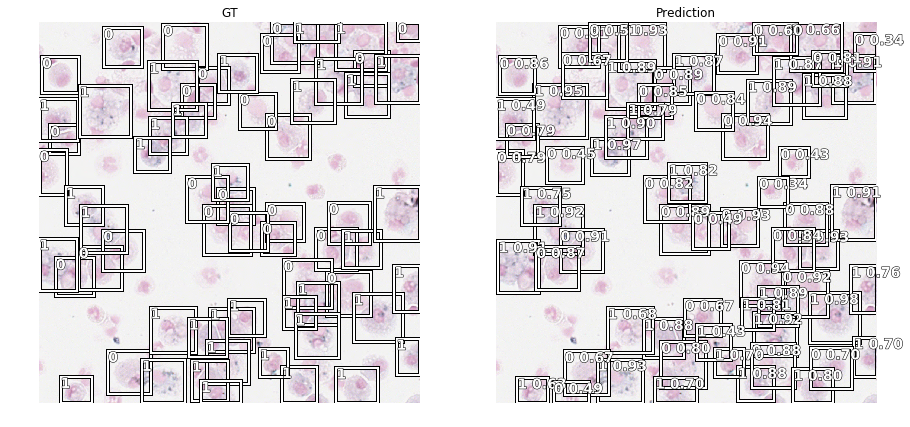

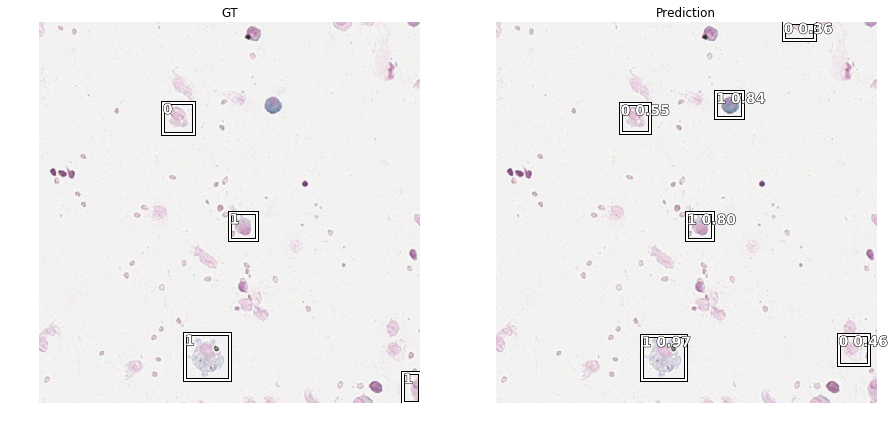

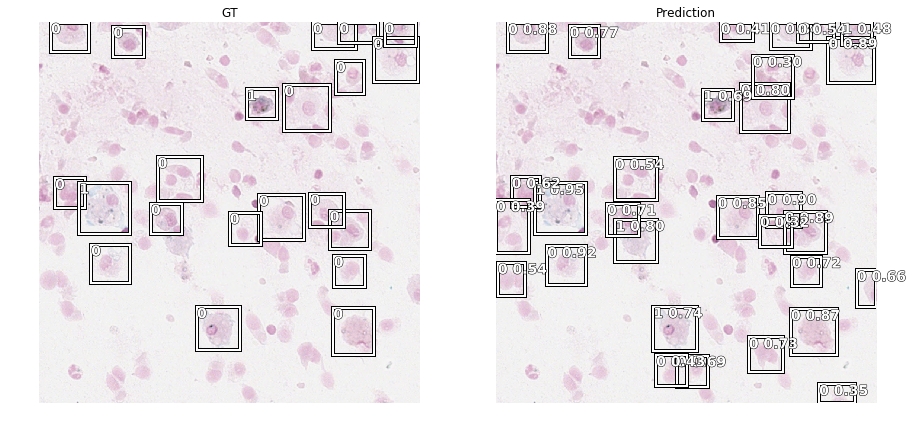

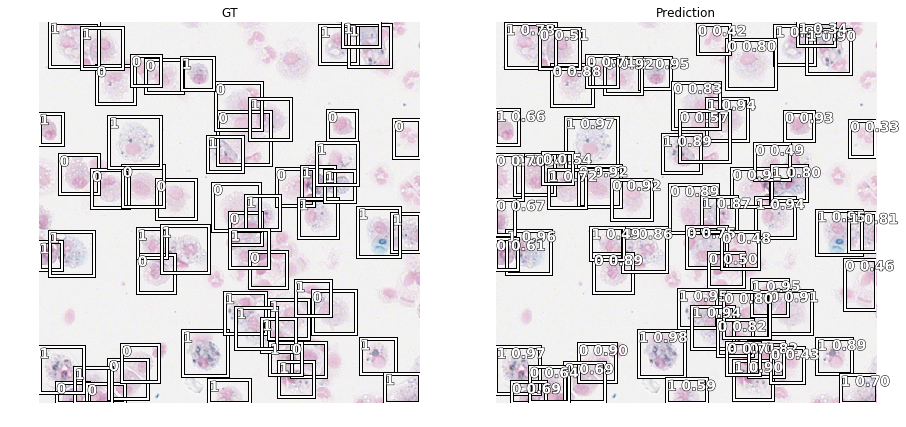

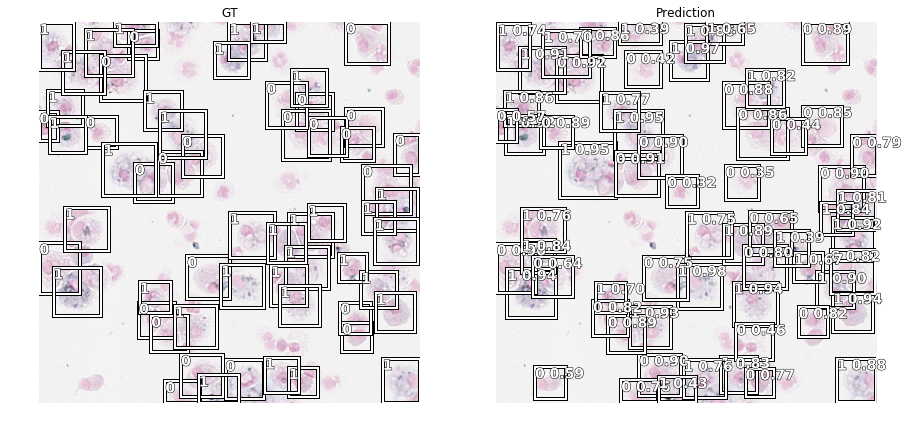

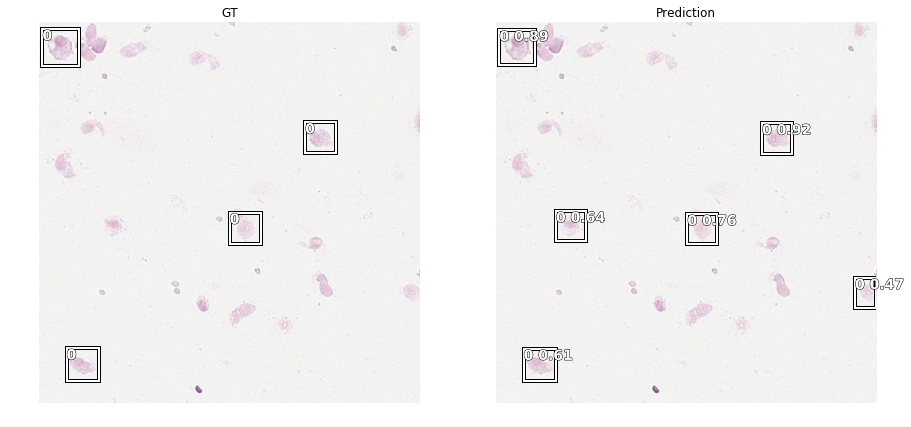

In [18]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=20)